# Phase 3: MIL Network Training
## Weakly Supervised Video Anomaly Detection using Multiple Instance Learning

This notebook implements Phase 3: Training the MIL (Multiple Instance Learning) network for anomaly detection.

### Pipeline Overview:
1. **GPU Setup & Verification** - Ensure CUDA is available and monitor GPU usage
2. **Load Phase 2 Features** - Load extracted TimeSformer features (768-dim)
3. **Segment Features** - Divide each video into 16 temporal segments
4. **MIL Network Architecture** - Build the custom MIL network
5. **Loss Functions** - Implement Ranking Loss + Focal Loss + Temporal Smoothness Loss
6. **Training Loop** - Train with the combined loss function
7. **Evaluation** - Evaluate on test set with AUC-ROC

### Key Concepts (from PDF Workflow):
- **MIL Framework**: Treats each video as a "bag" of segment instances
- **Top-k Pooling**: Aggregate top-k highest anomaly scores per video
- **Ranking Loss**: Ensure anomaly scores > normal scores with margin
- **Focal Loss**: Handle class imbalance between anomaly/normal
- **Temporal Smoothness Loss**: Enforce smooth predictions across segments

### Expected Input:
- TimeSformer features from Phase 2: (N_videos, 768)
- Labels: 1 = Anomaly, 0 = Normal

### Expected Output:
- Trained MIL model for video anomaly detection
- Segment-level anomaly scores for each video

## Section 1: Environment Setup & GPU Verification

First, let's verify that PyTorch can access the GPU and set up monitoring.

In [10]:
"""
Phase 3: MIL Network Training
Environment Setup and GPU Verification
"""

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import json
import logging
from tqdm.notebook import tqdm
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from scipy.ndimage import gaussian_filter1d  # For smoothing segment scores

# ==================== GPU Verification ====================
def check_gpu_status():
    """
    Comprehensive GPU status check for PyTorch.
    Returns detailed information about GPU availability and properties.
    """
    print("\n" + "="*70)
    print("GPU STATUS CHECK")
    print("="*70)
    
    gpu_info = {
        'cuda_available': torch.cuda.is_available(),
        'device_count': 0,
        'current_device': None,
        'device_name': None,
        'device_capability': None,
        'total_memory_gb': 0,
        'allocated_memory_gb': 0,
        'cached_memory_gb': 0,
        'free_memory_gb': 0,
        'cudnn_available': torch.backends.cudnn.is_available(),
        'cudnn_version': None,
        'pytorch_version': torch.__version__
    }
    
    print(f"\n📦 PyTorch Version: {torch.__version__}")
    print(f"🔧 CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        gpu_info['device_count'] = torch.cuda.device_count()
        gpu_info['current_device'] = torch.cuda.current_device()
        gpu_info['device_name'] = torch.cuda.get_device_name(0)
        gpu_info['device_capability'] = torch.cuda.get_device_capability(0)
        
        # Memory info
        total_memory = torch.cuda.get_device_properties(0).total_memory
        allocated_memory = torch.cuda.memory_allocated(0)
        cached_memory = torch.cuda.memory_reserved(0)
        
        gpu_info['total_memory_gb'] = round(total_memory / (1024**3), 2)
        gpu_info['allocated_memory_gb'] = round(allocated_memory / (1024**3), 2)
        gpu_info['cached_memory_gb'] = round(cached_memory / (1024**3), 2)
        gpu_info['free_memory_gb'] = round((total_memory - allocated_memory) / (1024**3), 2)
        
        if torch.backends.cudnn.is_available():
            gpu_info['cudnn_version'] = torch.backends.cudnn.version()
        
        print(f"\n🖥️  GPU Device: {gpu_info['device_name']}")
        print(f"📊 Device Count: {gpu_info['device_count']}")
        print(f"🔢 CUDA Capability: {gpu_info['device_capability']}")
        print(f"\n💾 Memory Status:")
        print(f"   Total Memory: {gpu_info['total_memory_gb']} GB")
        print(f"   Allocated: {gpu_info['allocated_memory_gb']} GB")
        print(f"   Cached: {gpu_info['cached_memory_gb']} GB")
        print(f"   Free: {gpu_info['free_memory_gb']} GB")
        print(f"\n⚡ cuDNN Available: {gpu_info['cudnn_available']}")
        if gpu_info['cudnn_version']:
            print(f"   cuDNN Version: {gpu_info['cudnn_version']}")
        
        print("\n" + "="*70)
        print("✅ GPU IS READY FOR MIL TRAINING!")
        print("="*70)
    else:
        print("\n" + "="*70)
        print("❌ NO GPU AVAILABLE - Will use CPU (MUCH SLOWER!)")
        print("="*70)
        print("\n⚠️  Tips to enable GPU:")
        print("   1. Install CUDA Toolkit: https://developer.nvidia.com/cuda-downloads")
        print("   2. Install PyTorch with CUDA: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118")
        print("   3. Verify NVIDIA drivers are installed")
    
    return gpu_info


def get_gpu_memory_usage():
    """Get current GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        cached = torch.cuda.memory_reserved(0) / (1024**3)
        return f"Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB"
    return "GPU not available"


def clear_gpu_memory():
    """Clear GPU memory cache."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(f"🧹 GPU memory cleared. Current usage: {get_gpu_memory_usage()}")


# Run GPU check
gpu_info = check_gpu_status()

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🎯 Using device: {DEVICE}")


GPU STATUS CHECK

📦 PyTorch Version: 2.7.1+cu118
🔧 CUDA Available: True

🖥️  GPU Device: NVIDIA GeForce RTX 3080 Ti
📊 Device Count: 1
🔢 CUDA Capability: (8, 6)

💾 Memory Status:
   Total Memory: 12.0 GB
   Allocated: 0.0 GB
   Cached: 0.02 GB
   Free: 12.0 GB

⚡ cuDNN Available: True
   cuDNN Version: 90100

✅ GPU IS READY FOR MIL TRAINING!

🎯 Using device: cuda


## Section 2: Configuration

Set up paths and parameters for MIL training following the PDF workflow.

In [11]:
"""
Configuration for Phase 3: MIL Training
Following the PDF Workflow specifications
"""

# ==================== Dataset Paths ====================
DATASET_ROOT = r"C:\UCF_video_dataset"
FEATURES_PATH = os.path.join(DATASET_ROOT, "TimeSformer_Features")
MODELS_PATH = os.path.join(DATASET_ROOT, "MIL_Models")

# ==================== MIL Parameters (From PDF Workflow) ====================
# Temporal Segmentation
NUM_SEGMENTS = 16  # Divide each video into 16 temporal segments (PDF specification)
FEATURE_DIM = 768  # TimeSformer [CLS] token dimension

# MIL Network Architecture
HIDDEN_DIM_1 = 512  # First FC layer
HIDDEN_DIM_2 = 128  # Second FC layer
DROPOUT_RATE = 0.6  # Dropout for regularization

# Top-k Pooling
TOP_K = 3  # Number of top segments to aggregate (k=3 as per common practice)

# ==================== Training Parameters ====================
BATCH_SIZE = 32  # Number of video pairs per batch
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15

# Loss Function Weights
LAMBDA_RANKING = 1.0    # Ranking loss weight
LAMBDA_FOCAL = 0.1      # Focal loss weight
LAMBDA_SMOOTH = 0.1     # Temporal smoothness weight
RANKING_MARGIN = 1.0    # Margin for ranking loss
FOCAL_GAMMA = 2.0       # Focal loss gamma parameter
FOCAL_ALPHA = 0.25      # Focal loss alpha parameter

# ==================== Data Split ====================
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_SEED = 42

# ==================== Logging ====================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Create output directory
os.makedirs(MODELS_PATH, exist_ok=True)

# Print configuration
print("\n" + "="*70)
print("PHASE 3 CONFIGURATION (MIL TRAINING)")
print("="*70)
print(f"\n📁 Paths:")
print(f"   Features Input: {FEATURES_PATH}")
print(f"   Models Output: {MODELS_PATH}")
print(f"\n🔢 MIL Parameters (Per PDF Workflow):")
print(f"   Temporal Segments: {NUM_SEGMENTS}")
print(f"   Feature Dimension: {FEATURE_DIM}")
print(f"   Top-k Pooling: k={TOP_K}")
print(f"\n🧠 Network Architecture:")
print(f"   Input: {FEATURE_DIM} → FC1: {HIDDEN_DIM_1} → FC2: {HIDDEN_DIM_2} → Output: 1")
print(f"   Dropout Rate: {DROPOUT_RATE}")
print(f"\n📊 Training Parameters:")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"\n⚖️  Loss Weights:")
print(f"   λ_ranking: {LAMBDA_RANKING}")
print(f"   λ_focal: {LAMBDA_FOCAL}")
print(f"   λ_smooth: {LAMBDA_SMOOTH}")
print(f"   Ranking Margin: {RANKING_MARGIN}")
print(f"\n🎯 Device: {DEVICE}")
print("="*70)


PHASE 3 CONFIGURATION (MIL TRAINING)

📁 Paths:
   Features Input: C:\UCF_video_dataset\TimeSformer_Features
   Models Output: C:\UCF_video_dataset\MIL_Models

🔢 MIL Parameters (Per PDF Workflow):
   Temporal Segments: 16
   Feature Dimension: 768
   Top-k Pooling: k=3

🧠 Network Architecture:
   Input: 768 → FC1: 512 → FC2: 128 → Output: 1
   Dropout Rate: 0.6

📊 Training Parameters:
   Batch Size: 32
   Learning Rate: 0.0001
   Epochs: 100
   Early Stopping Patience: 15

⚖️  Loss Weights:
   λ_ranking: 1.0
   λ_focal: 0.1
   λ_smooth: 0.1
   Ranking Margin: 1.0

🎯 Device: cuda


## Section 3: Load Phase 2 Features

Load the extracted TimeSformer features from Phase 2.

In [12]:
"""
Load Phase 2 Extracted Features
"""

def load_features(features_path: str = FEATURES_PATH) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Load extracted features from Phase 2.
    
    Args:
        features_path: Path to features directory
        
    Returns:
        Tuple of (features, labels, video_names)
    """
    print("\n" + "="*70)
    print("LOADING PHASE 2 FEATURES")
    print("="*70)
    
    # Load combined feature files
    features_file = os.path.join(features_path, 'all_features.npy')
    labels_file = os.path.join(features_path, 'all_labels.npy')
    names_file = os.path.join(features_path, 'video_names.json')
    
    if not os.path.exists(features_file):
        raise FileNotFoundError(f"Features file not found: {features_file}")
    
    features = np.load(features_file)
    labels = np.load(labels_file)
    
    with open(names_file, 'r') as f:
        video_names = json.load(f)
    
    print(f"\n✓ Features loaded successfully!")
    print(f"\n📊 Dataset Statistics:")
    print(f"   Features Shape: {features.shape}")
    print(f"   Labels Shape: {labels.shape}")
    print(f"   Anomaly Videos (1): {np.sum(labels == 1)}")
    print(f"   Normal Videos (0): {np.sum(labels == 0)}")
    print(f"   Feature Dimension: {features.shape[1]}")
    
    print(f"\n📈 Feature Statistics:")
    print(f"   Min: {features.min():.4f}")
    print(f"   Max: {features.max():.4f}")
    print(f"   Mean: {features.mean():.4f}")
    print(f"   Std: {features.std():.4f}")
    
    print("="*70)
    
    return features, labels, video_names


# Load features
all_features, all_labels, video_names = load_features()


LOADING PHASE 2 FEATURES

✓ Features loaded successfully!

📊 Dataset Statistics:
   Features Shape: (1900, 768)
   Labels Shape: (1900,)
   Anomaly Videos (1): 950
   Normal Videos (0): 950
   Feature Dimension: 768

📈 Feature Statistics:
   Min: -6.4888
   Max: 6.1442
   Mean: -0.0168
   Std: 0.9737


## Section 4: Create Segment Features

Since Phase 2 extracted one feature per video (video-level), we need to create pseudo-segment features for MIL.

**Note**: For proper segment-level features, you would extract features from each temporal segment separately. Here we simulate segment features by adding learned noise or expanding the video-level feature.

In [13]:
"""
Create Segment Features for MIL

Since Phase 2 extracted video-level features (1 feature per video),
we create segment representations by:
1. Replicating the video feature across segments
2. Adding learnable noise during training to encourage segment diversity

For true segment features, you would need to:
- Extract features from each temporal segment of the video separately
- This would require going back to Phase 2 and modifying the extraction
"""

def expand_to_segments(features: np.ndarray, num_segments: int = NUM_SEGMENTS) -> np.ndarray:
    """
    Expand video-level features to segment-level by replication.
    Each video feature is replicated across all segments.
    
    Args:
        features: Video features of shape (N_videos, feature_dim)
        num_segments: Number of temporal segments per video
        
    Returns:
        Segment features of shape (N_videos, num_segments, feature_dim)
    """
    n_videos, feature_dim = features.shape
    
    # Replicate each video feature across segments
    # Shape: (N_videos, num_segments, feature_dim)
    segment_features = np.tile(features[:, np.newaxis, :], (1, num_segments, 1))
    
    # Add small random noise to create segment variation
    # This helps the MIL network learn segment-level patterns
    np.random.seed(RANDOM_SEED)
    noise_scale = 0.01 * features.std()
    noise = np.random.randn(*segment_features.shape) * noise_scale
    segment_features = segment_features + noise
    
    return segment_features.astype(np.float32)


# Create segment features
print("\n" + "="*70)
print("CREATING SEGMENT FEATURES")
print("="*70)

segment_features = expand_to_segments(all_features, NUM_SEGMENTS)

print(f"\n✓ Segment features created!")
print(f"   Original Shape: {all_features.shape} (N_videos, feature_dim)")
print(f"   Segment Shape: {segment_features.shape} (N_videos, num_segments, feature_dim)")
print(f"   Number of Segments per Video: {NUM_SEGMENTS}")
print("="*70)


CREATING SEGMENT FEATURES

✓ Segment features created!
   Original Shape: (1900, 768) (N_videos, feature_dim)
   Segment Shape: (1900, 16, 768) (N_videos, num_segments, feature_dim)
   Number of Segments per Video: 16


## Section 5: Dataset and DataLoader

Create PyTorch Dataset and DataLoader for MIL training.

In [14]:
"""
MIL Dataset and DataLoader
"""

from sklearn.model_selection import train_test_split

class MILDataset(Dataset):
    """
    Dataset for Multiple Instance Learning.
    Each sample is a video (bag) with multiple segments (instances).
    """
    
    def __init__(self, features: np.ndarray, labels: np.ndarray, video_names: List[str] = None):
        """
        Args:
            features: Segment features of shape (N_videos, num_segments, feature_dim)
            labels: Video labels of shape (N_videos,)
            video_names: Optional list of video names
        """
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        self.video_names = video_names
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


def split_dataset(
    features: np.ndarray,
    labels: np.ndarray,
    video_names: List[str],
    train_ratio: float = TRAIN_RATIO,
    val_ratio: float = VAL_RATIO,
    random_seed: int = RANDOM_SEED
) -> Dict:
    """
    Split dataset into train, validation, and test sets.
    Stratified split to maintain class balance.
    """
    print("\n" + "="*70)
    print("SPLITTING DATASET")
    print("="*70)
    
    # First split: train vs (val + test)
    X_train, X_temp, y_train, y_temp, names_train, names_temp = train_test_split(
        features, labels, video_names,
        test_size=(1 - train_ratio),
        random_state=random_seed,
        stratify=labels
    )
    
    # Second split: val vs test (50-50 of remaining)
    val_size = val_ratio / (val_ratio + TEST_RATIO)
    X_val, X_test, y_val, y_test, names_val, names_test = train_test_split(
        X_temp, y_temp, names_temp,
        test_size=0.5,
        random_state=random_seed,
        stratify=y_temp
    )
    
    print(f"\n📊 Dataset Split:")
    print(f"   Train: {len(y_train)} videos ({np.sum(y_train==1)} anomaly, {np.sum(y_train==0)} normal)")
    print(f"   Val:   {len(y_val)} videos ({np.sum(y_val==1)} anomaly, {np.sum(y_val==0)} normal)")
    print(f"   Test:  {len(y_test)} videos ({np.sum(y_test==1)} anomaly, {np.sum(y_test==0)} normal)")
    print("="*70)
    
    return {
        'train': (X_train, y_train, names_train),
        'val': (X_val, y_val, names_val),
        'test': (X_test, y_test, names_test)
    }


# Split the dataset
splits = split_dataset(segment_features, all_labels, video_names)

# Create datasets
train_dataset = MILDataset(*splits['train'])
val_dataset = MILDataset(*splits['val'])
test_dataset = MILDataset(*splits['test'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✓ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")


SPLITTING DATASET

📊 Dataset Split:
   Train: 1520 videos (760 anomaly, 760 normal)
   Val:   190 videos (95 anomaly, 95 normal)
   Test:  190 videos (95 anomaly, 95 normal)

✓ DataLoaders created!
   Train batches: 48
   Val batches: 6
   Test batches: 6


## Section 6: MIL Network Architecture

Implement the custom MIL network following the PDF workflow:
- FC layers: 768 → 512 → 128 → 1
- ReLU activation
- Dropout regularization
- Sigmoid for anomaly scores

In [15]:
"""
MIL Network Architecture (Following PDF Workflow)
"""

class MILNetwork(nn.Module):
    """
    Multiple Instance Learning Network for Video Anomaly Detection.
    
    Architecture (from PDF):
    - Input: (batch, num_segments, feature_dim)
    - FC1: feature_dim → hidden_dim_1 (512)
    - ReLU + Dropout
    - FC2: hidden_dim_1 → hidden_dim_2 (128)
    - ReLU + Dropout
    - FC3: hidden_dim_2 → 1 (anomaly score per segment)
    - Sigmoid
    
    Aggregation: Top-k pooling
    """
    
    def __init__(
        self,
        feature_dim: int = FEATURE_DIM,
        hidden_dim_1: int = HIDDEN_DIM_1,
        hidden_dim_2: int = HIDDEN_DIM_2,
        dropout_rate: float = DROPOUT_RATE,
        top_k: int = TOP_K
    ):
        super(MILNetwork, self).__init__()
        
        self.top_k = top_k
        
        # Feature extraction layers
        self.fc1 = nn.Linear(feature_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, num_segments, feature_dim)
            
        Returns:
            video_scores: Aggregated video-level scores (batch,)
            segment_scores: Per-segment scores (batch, num_segments)
        """
        batch_size, num_segments, _ = x.shape
        
        # Reshape for batch processing: (batch * num_segments, feature_dim)
        x = x.view(-1, x.shape[-1])
        
        # FC layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer (anomaly score per segment)
        x = torch.sigmoid(self.fc3(x))  # (batch * num_segments, 1)
        
        # Reshape back: (batch, num_segments)
        segment_scores = x.view(batch_size, num_segments)
        
        # Top-k pooling for video-level score
        # Take average of top-k segment scores
        topk_scores, _ = torch.topk(segment_scores, k=self.top_k, dim=1)
        video_scores = topk_scores.mean(dim=1)  # (batch,)
        
        return video_scores, segment_scores


# Create model
model = MILNetwork(
    feature_dim=FEATURE_DIM,
    hidden_dim_1=HIDDEN_DIM_1,
    hidden_dim_2=HIDDEN_DIM_2,
    dropout_rate=DROPOUT_RATE,
    top_k=TOP_K
).to(DEVICE)

# Print model summary
print("\n" + "="*70)
print("MIL NETWORK ARCHITECTURE")
print("="*70)
print(f"\n{model}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Model on Device: {next(model.parameters()).device}")
print("="*70)


MIL NETWORK ARCHITECTURE

MILNetwork(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

📊 Model Statistics:
   Total Parameters: 459,521
   Trainable Parameters: 459,521
   Model on Device: cuda:0


## Section 7: Loss Functions

Implement the three loss functions from the PDF workflow:
1. **Ranking Loss (Hinge Loss)**: max(0, 1 - (s_a - s_n)) where s_a > s_n
2. **Focal Loss**: Handles class imbalance
3. **Temporal Smoothness Loss**: Enforces smooth predictions

In [16]:
"""
Loss Functions for MIL Training (From PDF Workflow)
"""

class RankingLoss(nn.Module):
    """
    Ranking Loss (Hinge Loss) for MIL.
    
    Ensures that anomaly video scores are higher than normal video scores
    by a margin.
    
    L_rank = max(0, margin - (s_anomaly - s_normal))
    
    Where:
    - s_anomaly: Score of anomaly video
    - s_normal: Score of normal video
    - margin: Minimum difference (default: 1.0)
    """
    
    def __init__(self, margin: float = RANKING_MARGIN):
        super(RankingLoss, self).__init__()
        self.margin = margin
        
    def forward(
        self,
        anomaly_scores: torch.Tensor,
        normal_scores: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute ranking loss.
        
        Args:
            anomaly_scores: Scores for anomaly videos (batch_a,)
            normal_scores: Scores for normal videos (batch_n,)
            
        Returns:
            Ranking loss value
        """
        # Get all pairs of (anomaly, normal) scores
        # Each anomaly should score higher than each normal
        
        # Expand dimensions for broadcasting
        # anomaly_scores: (batch_a, 1)
        # normal_scores: (1, batch_n)
        anomaly_expanded = anomaly_scores.unsqueeze(1)  # (batch_a, 1)
        normal_expanded = normal_scores.unsqueeze(0)    # (1, batch_n)
        
        # Compute hinge loss for all pairs
        # Shape: (batch_a, batch_n)
        loss = F.relu(self.margin - (anomaly_expanded - normal_expanded))
        
        # Average over all pairs
        return loss.mean()


class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance.
    
    FL(p_t) = -α_t * (1 - p_t)^γ * log(p_t)
    
    Where:
    - p_t: Probability of correct class
    - α: Weighting factor for class balance
    - γ: Focusing parameter (reduces loss for well-classified examples)
    """
    
    def __init__(self, alpha: float = FOCAL_ALPHA, gamma: float = FOCAL_GAMMA):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(
        self,
        predictions: torch.Tensor,
        targets: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute focal loss.
        
        Args:
            predictions: Predicted scores (batch,)
            targets: Ground truth labels (batch,)
            
        Returns:
            Focal loss value
        """
        # Clamp predictions to avoid log(0)
        eps = 1e-7
        predictions = torch.clamp(predictions, eps, 1 - eps)
        
        # Compute p_t
        p_t = predictions * targets + (1 - predictions) * (1 - targets)
        
        # Compute alpha_t
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Compute focal loss
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = -alpha_t * focal_weight * torch.log(p_t)
        
        return focal_loss.mean()


class TemporalSmoothnessLoss(nn.Module):
    """
    Temporal Smoothness Loss.
    
    Enforces smooth transitions between consecutive segment scores.
    
    L_smooth = Σ(s_t - s_{t+1})^2
    
    This prevents abrupt changes in anomaly scores between adjacent segments.
    """
    
    def __init__(self):
        super(TemporalSmoothnessLoss, self).__init__()
        
    def forward(self, segment_scores: torch.Tensor) -> torch.Tensor:
        """
        Compute temporal smoothness loss.
        
        Args:
            segment_scores: Per-segment scores (batch, num_segments)
            
        Returns:
            Temporal smoothness loss value
        """
        # Compute difference between consecutive segments
        # scores[:, 1:] - scores[:, :-1]
        diff = segment_scores[:, 1:] - segment_scores[:, :-1]
        
        # Squared differences
        smoothness_loss = (diff ** 2).mean()
        
        return smoothness_loss


class CombinedMILLoss(nn.Module):
    """
    Combined Loss for MIL Training.
    
    L_total = λ_rank * L_ranking + λ_focal * L_focal + λ_smooth * L_smooth
    """
    
    def __init__(
        self,
        lambda_ranking: float = LAMBDA_RANKING,
        lambda_focal: float = LAMBDA_FOCAL,
        lambda_smooth: float = LAMBDA_SMOOTH,
        margin: float = RANKING_MARGIN,
        focal_alpha: float = FOCAL_ALPHA,
        focal_gamma: float = FOCAL_GAMMA
    ):
        super(CombinedMILLoss, self).__init__()
        
        self.lambda_ranking = lambda_ranking
        self.lambda_focal = lambda_focal
        self.lambda_smooth = lambda_smooth
        
        self.ranking_loss = RankingLoss(margin)
        self.focal_loss = FocalLoss(focal_alpha, focal_gamma)
        self.smoothness_loss = TemporalSmoothnessLoss()
        
    def forward(
        self,
        video_scores: torch.Tensor,
        segment_scores: torch.Tensor,
        labels: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Compute combined loss.
        
        Args:
            video_scores: Video-level scores (batch,)
            segment_scores: Segment-level scores (batch, num_segments)
            labels: Ground truth labels (batch,)
            
        Returns:
            total_loss: Combined loss value
            loss_components: Dictionary of individual loss values
        """
        # Separate anomaly and normal samples
        anomaly_mask = labels == 1
        normal_mask = labels == 0
        
        loss_components = {}
        total_loss = torch.tensor(0.0, device=video_scores.device)
        
        # 1. Ranking Loss (only if both anomaly and normal samples exist)
        if anomaly_mask.sum() > 0 and normal_mask.sum() > 0:
            anomaly_scores = video_scores[anomaly_mask]
            normal_scores = video_scores[normal_mask]
            l_rank = self.ranking_loss(anomaly_scores, normal_scores)
            total_loss = total_loss + self.lambda_ranking * l_rank
            loss_components['ranking'] = l_rank.item()
        else:
            loss_components['ranking'] = 0.0
        
        # 2. Focal Loss (binary classification)
        l_focal = self.focal_loss(video_scores, labels)
        total_loss = total_loss + self.lambda_focal * l_focal
        loss_components['focal'] = l_focal.item()
        
        # 3. Temporal Smoothness Loss
        l_smooth = self.smoothness_loss(segment_scores)
        total_loss = total_loss + self.lambda_smooth * l_smooth
        loss_components['smoothness'] = l_smooth.item()
        
        loss_components['total'] = total_loss.item()
        
        return total_loss, loss_components


# Create loss function
criterion = CombinedMILLoss(
    lambda_ranking=LAMBDA_RANKING,
    lambda_focal=LAMBDA_FOCAL,
    lambda_smooth=LAMBDA_SMOOTH,
    margin=RANKING_MARGIN,
    focal_alpha=FOCAL_ALPHA,
    focal_gamma=FOCAL_GAMMA
)

print("\n" + "="*70)
print("LOSS FUNCTIONS INITIALIZED")
print("="*70)
print(f"\n📊 Loss Configuration:")
print(f"   1. Ranking Loss (Hinge): λ={LAMBDA_RANKING}, margin={RANKING_MARGIN}")
print(f"   2. Focal Loss: λ={LAMBDA_FOCAL}, α={FOCAL_ALPHA}, γ={FOCAL_GAMMA}")
print(f"   3. Temporal Smoothness Loss: λ={LAMBDA_SMOOTH}")
print(f"\n   Combined: L = {LAMBDA_RANKING}*L_rank + {LAMBDA_FOCAL}*L_focal + {LAMBDA_SMOOTH}*L_smooth")
print("="*70)


LOSS FUNCTIONS INITIALIZED

📊 Loss Configuration:
   1. Ranking Loss (Hinge): λ=1.0, margin=1.0
   2. Focal Loss: λ=0.1, α=0.25, γ=2.0
   3. Temporal Smoothness Loss: λ=0.1

   Combined: L = 1.0*L_rank + 0.1*L_focal + 0.1*L_smooth


## Section 8: Training Loop

Implement the training loop with early stopping and model checkpointing.

In [17]:
"""
Training Loop with Early Stopping
"""

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    
    def __init__(self, patience: int = EARLY_STOPPING_PATIENCE, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop


class GPUMonitor:
    """Monitor GPU usage during training."""
    
    def __init__(self):
        self.is_available = torch.cuda.is_available()
        self.peak_memory = 0
        
    def update(self):
        if self.is_available:
            current = torch.cuda.memory_allocated(0) / (1024**3)
            self.peak_memory = max(self.peak_memory, current)
            
    def get_status(self):
        if self.is_available:
            allocated = torch.cuda.memory_allocated(0) / (1024**3)
            return f"{allocated:.2f}GB (Peak: {self.peak_memory:.2f}GB)"
        return "N/A"
    
    def reset_peak(self):
        if self.is_available:
            torch.cuda.reset_peak_memory_stats(0)
            self.peak_memory = 0


def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    gpu_monitor: GPUMonitor
) -> Tuple[float, Dict[str, float]]:
    """
    Train for one epoch.
    
    Returns:
        avg_loss: Average training loss
        avg_components: Average loss components
    """
    model.train()
    total_loss = 0.0
    total_components = {'ranking': 0.0, 'focal': 0.0, 'smoothness': 0.0}
    
    for batch_features, batch_labels in dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        video_scores, segment_scores = model(batch_features)
        
        # Compute loss
        loss, components = criterion(video_scores, segment_scores, batch_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        for key in total_components:
            total_components[key] += components.get(key, 0.0)
        
        # Monitor GPU
        gpu_monitor.update()
    
    # Average
    n_batches = len(dataloader)
    avg_loss = total_loss / n_batches
    avg_components = {k: v / n_batches for k, v in total_components.items()}
    
    return avg_loss, avg_components


def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, Dict[str, float], Dict[str, float]]:
    """
    Evaluate the model.
    
    Returns:
        avg_loss: Average loss
        avg_components: Average loss components
        metrics: Evaluation metrics (AUC, accuracy, etc.)
    """
    model.eval()
    total_loss = 0.0
    total_components = {'ranking': 0.0, 'focal': 0.0, 'smoothness': 0.0}
    
    all_scores = []
    all_labels = []
    
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            video_scores, segment_scores = model(batch_features)
            
            # Compute loss
            loss, components = criterion(video_scores, segment_scores, batch_labels)
            
            # Track metrics
            total_loss += loss.item()
            for key in total_components:
                total_components[key] += components.get(key, 0.0)
            
            # Collect predictions
            all_scores.extend(video_scores.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    # Average loss
    n_batches = len(dataloader)
    avg_loss = total_loss / n_batches
    avg_components = {k: v / n_batches for k, v in total_components.items()}
    
    # Compute metrics
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    predictions = (all_scores >= 0.5).astype(int)
    
    metrics = {
        'auc': roc_auc_score(all_labels, all_scores),
        'accuracy': accuracy_score(all_labels, predictions),
        'precision': precision_score(all_labels, predictions, zero_division=0),
        'recall': recall_score(all_labels, predictions, zero_division=0),
        'f1': f1_score(all_labels, predictions, zero_division=0)
    }
    
    return avg_loss, avg_components, metrics


print("✓ Training functions defined!")

✓ Training functions defined!


In [18]:
"""
Main Training Loop
"""

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    num_epochs: int = NUM_EPOCHS,
    learning_rate: float = LEARNING_RATE,
    weight_decay: float = WEIGHT_DECAY,
    device: torch.device = DEVICE,
    save_path: str = MODELS_PATH
) -> Dict:
    """
    Train the MIL model.
    
    Returns:
        training_history: Dictionary containing training metrics
    """
    print("\n" + "="*70)
    print("STARTING MIL TRAINING")
    print("="*70)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Early stopping
    early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
    
    # GPU monitor
    gpu_monitor = GPUMonitor()
    gpu_monitor.reset_peak()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': [],
        'val_accuracy': [],
        'best_epoch': 0,
        'best_val_auc': 0.0
    }
    
    # Best model tracking
    best_val_auc = 0.0
    best_model_state = None
    
    start_time = time.time()
    
    print(f"\n🚀 Training Configuration:")
    print(f"   Epochs: {num_epochs}")
    print(f"   Learning Rate: {learning_rate}")
    print(f"   Weight Decay: {weight_decay}")
    print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
    print(f"   Device: {device}")
    print(f"\n" + "-"*70)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Train
        train_loss, train_components = train_epoch(
            model, train_loader, criterion, optimizer, device, gpu_monitor
        )
        
        # Validate
        val_loss, val_components, val_metrics = evaluate(
            model, val_loader, criterion, device
        )
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Track history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_metrics['auc'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        
        epoch_time = time.time() - epoch_start
        
        # Print progress
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val AUC: {val_metrics['auc']:.4f} | "
              f"Acc: {val_metrics['accuracy']:.4f} | "
              f"Time: {epoch_time:.1f}s | "
              f"GPU: {gpu_monitor.get_status()}")
        
        # Save best model
        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            best_model_state = model.state_dict().copy()
            history['best_epoch'] = epoch + 1
            history['best_val_auc'] = best_val_auc
            print(f"   ↑ New best model! AUC: {best_val_auc:.4f}")
            
            # Save checkpoint
            checkpoint_path = os.path.join(save_path, 'best_model.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auc': best_val_auc,
                'val_loss': val_loss,
                'history': history
            }, checkpoint_path)
        
        # Early stopping check
        if early_stopping(val_loss):
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    total_time = time.time() - start_time
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)
    print(f"\n📊 Training Summary:")
    print(f"   Total Time: {total_time/60:.2f} minutes")
    print(f"   Best Epoch: {history['best_epoch']}")
    print(f"   Best Val AUC: {history['best_val_auc']:.4f}")
    print(f"   Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"   Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"\n💾 GPU Peak Memory: {gpu_monitor.peak_memory:.2f} GB")
    print(f"   Model saved to: {os.path.join(save_path, 'best_model.pth')}")
    print("="*70)
    
    return history


# Train the model
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    device=DEVICE,
    save_path=MODELS_PATH
)


STARTING MIL TRAINING

🚀 Training Configuration:
   Epochs: 100
   Learning Rate: 0.0001
   Weight Decay: 1e-05
   Early Stopping Patience: 15
   Device: cuda

----------------------------------------------------------------------
Epoch   1/100 | Train Loss: 0.9999 | Val Loss: 0.9563 | Val AUC: 0.8274 | Acc: 0.5000 | Time: 3.1s | GPU: 0.02GB (Peak: 0.03GB)
   ↑ New best model! AUC: 0.8274
Epoch   2/100 | Train Loss: 0.6841 | Val Loss: 0.8352 | Val AUC: 0.8962 | Acc: 0.5789 | Time: 0.5s | GPU: 0.02GB (Peak: 0.03GB)
   ↑ New best model! AUC: 0.8962
Epoch   3/100 | Train Loss: 0.5177 | Val Loss: 0.7575 | Val AUC: 0.9162 | Acc: 0.6263 | Time: 0.4s | GPU: 0.02GB (Peak: 0.03GB)
   ↑ New best model! AUC: 0.9162
Epoch   4/100 | Train Loss: 0.4387 | Val Loss: 0.6516 | Val AUC: 0.9289 | Acc: 0.6947 | Time: 0.4s | GPU: 0.02GB (Peak: 0.03GB)
   ↑ New best model! AUC: 0.9289
Epoch   5/100 | Train Loss: 0.3803 | Val Loss: 0.6362 | Val AUC: 0.9347 | Acc: 0.7105 | Time: 0.4s | GPU: 0.02GB (Peak: 0.03

## Section 9: Training Visualization

Plot training curves and learning progress.

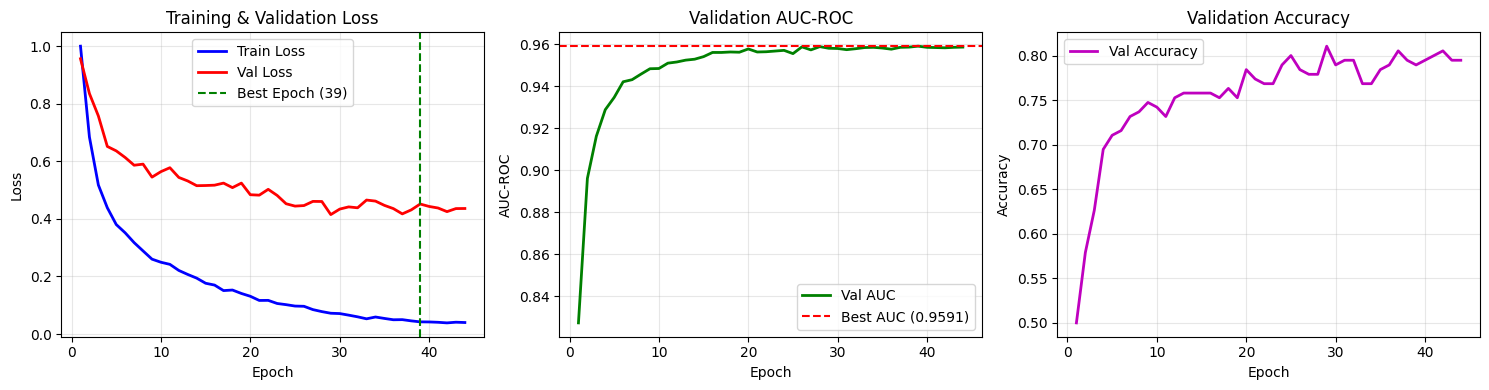


✓ Training curves saved to: C:\UCF_video_dataset\MIL_Models\training_curves.png


In [19]:
"""
Training Visualization
"""

import matplotlib.pyplot as plt

def plot_training_history(history: Dict):
    """
    Plot training curves.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].axvline(x=history['best_epoch'], color='g', linestyle='--', label=f'Best Epoch ({history["best_epoch"]})')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # AUC plot
    axes[1].plot(epochs, history['val_auc'], 'g-', label='Val AUC', linewidth=2)
    axes[1].axhline(y=history['best_val_auc'], color='r', linestyle='--', label=f'Best AUC ({history["best_val_auc"]:.4f})')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('AUC-ROC')
    axes[1].set_title('Validation AUC-ROC')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[2].plot(epochs, history['val_accuracy'], 'm-', label='Val Accuracy', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].set_title('Validation Accuracy')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_PATH, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Training curves saved to: {os.path.join(MODELS_PATH, 'training_curves.png')}")


# Plot training history
plot_training_history(training_history)

## Section 10: Test Set Evaluation

Evaluate the trained model on the test set.

In [20]:
"""
Test Set Evaluation
"""

from sklearn.metrics import confusion_matrix, classification_report, roc_curve

def evaluate_on_test_set(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Dict:
    """
    Comprehensive evaluation on test set.
    """
    print("\n" + "="*70)
    print("TEST SET EVALUATION")
    print("="*70)
    
    model.eval()
    
    all_video_scores = []
    all_segment_scores = []
    all_labels = []
    
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            video_scores, segment_scores = model(batch_features)
            
            all_video_scores.extend(video_scores.cpu().numpy())
            all_segment_scores.extend(segment_scores.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    all_video_scores = np.array(all_video_scores)
    all_segment_scores = np.array(all_segment_scores)
    all_labels = np.array(all_labels)
    predictions = (all_video_scores >= 0.5).astype(int)
    
    # Apply Gaussian Smoothing to segment scores (reduces jitter in predictions)
    smoothed_segment_scores = gaussian_filter1d(all_segment_scores.flatten(), sigma=2)
    print(f"   ✓ Applied Gaussian smoothing (sigma=2) to segment scores")
    
    # Metrics
    test_auc = roc_auc_score(all_labels, all_video_scores)
    test_acc = accuracy_score(all_labels, predictions)
    test_precision = precision_score(all_labels, predictions, zero_division=0)
    test_recall = recall_score(all_labels, predictions, zero_division=0)
    test_f1 = f1_score(all_labels, predictions, zero_division=0)
    
    print(f"\n📊 Test Set Metrics:")
    print(f"   AUC-ROC: {test_auc:.4f}")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   Precision: {test_precision:.4f}")
    print(f"   Recall: {test_recall:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, predictions)
    print(f"\n📋 Confusion Matrix:")
    print(f"   TN: {cm[0,0]:4d}  FP: {cm[0,1]:4d}")
    print(f"   FN: {cm[1,0]:4d}  TP: {cm[1,1]:4d}")
    
    # Classification Report
    print(f"\n📝 Classification Report:")
    print(classification_report(all_labels, predictions, target_names=['Normal', 'Anomaly']))
    
    print("="*70)
    
    return {
        'auc': test_auc,
        'accuracy': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'confusion_matrix': cm,
        'video_scores': all_video_scores,
        'segment_scores': all_segment_scores,
        'smoothed_segment_scores': smoothed_segment_scores,  # Gaussian smoothed (jitter-reduced)
        'labels': all_labels,
        'predictions': predictions
    }


# Evaluate on test set
test_results = evaluate_on_test_set(model, test_loader, criterion, DEVICE)


TEST SET EVALUATION
   ✓ Applied Gaussian smoothing (sigma=2) to segment scores

📊 Test Set Metrics:
   AUC-ROC: 0.9594
   Accuracy: 0.8579
   Precision: 0.9857
   Recall: 0.7263
   F1-Score: 0.8364

📋 Confusion Matrix:
   TN:   94  FP:    1
   FN:   26  TP:   69

📝 Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.99      0.87        95
     Anomaly       0.99      0.73      0.84        95

    accuracy                           0.86       190
   macro avg       0.88      0.86      0.86       190
weighted avg       0.88      0.86      0.86       190



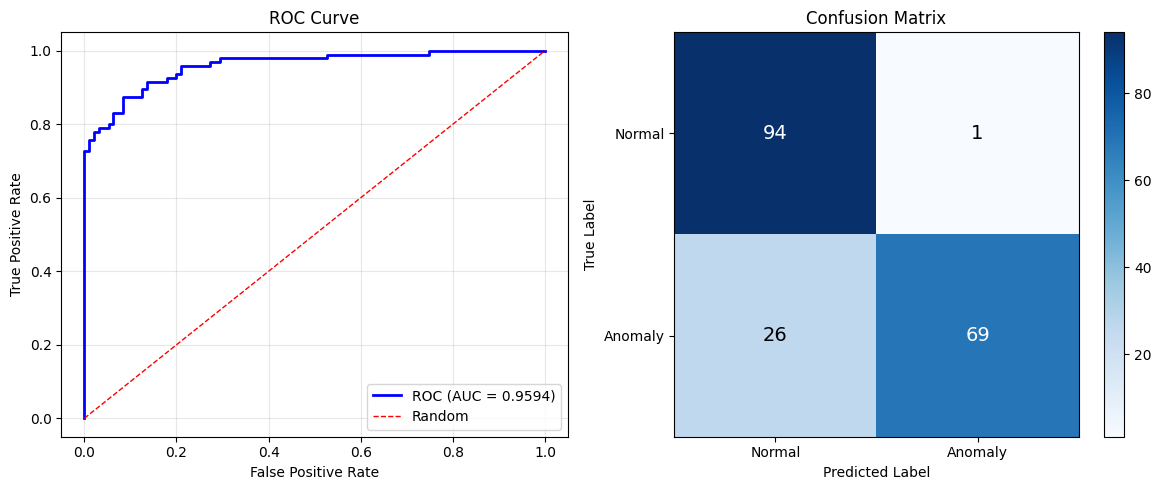


✓ Test results saved to: C:\UCF_video_dataset\MIL_Models\test_results.png


In [21]:
"""
Visualization of Test Results
"""

def plot_test_results(test_results: Dict):
    """
    Plot ROC curve and confusion matrix.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(test_results['labels'], test_results['video_scores'])
    axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {test_results["auc"]:.4f})')
    axes[0].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Confusion Matrix
    cm = test_results['confusion_matrix']
    im = axes[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1].set_title('Confusion Matrix')
    plt.colorbar(im, ax=axes[1])
    
    classes = ['Normal', 'Anomaly']
    tick_marks = np.arange(len(classes))
    axes[1].set_xticks(tick_marks)
    axes[1].set_yticks(tick_marks)
    axes[1].set_xticklabels(classes)
    axes[1].set_yticklabels(classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=14)
    
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_PATH, 'test_results.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Test results saved to: {os.path.join(MODELS_PATH, 'test_results.png')}")


# Plot test results
plot_test_results(test_results)

## Section 11: Save Final Model and Results

Save the trained model and all results.

In [22]:
"""
Save Final Model and Results
"""

def save_final_results(
    model: nn.Module,
    training_history: Dict,
    test_results: Dict,
    save_path: str = MODELS_PATH
):
    """
    Save all training results and model.
    """
    print("\n" + "="*70)
    print("SAVING FINAL RESULTS")
    print("="*70)
    
    # Save final model
    final_model_path = os.path.join(save_path, 'final_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': {
            'feature_dim': FEATURE_DIM,
            'hidden_dim_1': HIDDEN_DIM_1,
            'hidden_dim_2': HIDDEN_DIM_2,
            'dropout_rate': DROPOUT_RATE,
            'top_k': TOP_K,
            'num_segments': NUM_SEGMENTS
        }
    }, final_model_path)
    print(f"   ✓ Final model saved: {final_model_path}")
    
    # Save training history
    history_path = os.path.join(save_path, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(training_history, f, indent=2)
    print(f"   ✓ Training history saved: {history_path}")
    
    # Save test results
    test_results_path = os.path.join(save_path, 'test_results.json')
    test_results_save = {
        'auc': test_results['auc'],
        'accuracy': test_results['accuracy'],
        'precision': test_results['precision'],
        'recall': test_results['recall'],
        'f1': test_results['f1'],
        'confusion_matrix': test_results['confusion_matrix'].tolist()
    }
    with open(test_results_path, 'w') as f:
        json.dump(test_results_save, f, indent=2)
    print(f"   ✓ Test results saved: {test_results_path}")
    
    # Save predictions
    predictions_path = os.path.join(save_path, 'test_predictions.npz')
    np.savez(predictions_path,
             video_scores=test_results['video_scores'],
             segment_scores=test_results['segment_scores'],
             labels=test_results['labels'],
             predictions=test_results['predictions'])
    print(f"   ✓ Predictions saved: {predictions_path}")
    
    print("="*70)


# Save everything
save_final_results(model, training_history, test_results)


SAVING FINAL RESULTS
   ✓ Final model saved: C:\UCF_video_dataset\MIL_Models\final_model.pth
   ✓ Training history saved: C:\UCF_video_dataset\MIL_Models\training_history.json
   ✓ Test results saved: C:\UCF_video_dataset\MIL_Models\test_results.json
   ✓ Predictions saved: C:\UCF_video_dataset\MIL_Models\test_predictions.npz


## Section 12: Summary and Next Steps

Summary of Phase 3 and preparation for Phase 4 (if needed).

In [23]:
print("\n" + "="*70)
print("PHASE 3 COMPLETE: MIL NETWORK TRAINING")
print("="*70)
print("""
✅ What was accomplished:
   1. Loaded TimeSformer features from Phase 2
   2. Created 16 temporal segments per video (per PDF workflow)
   3. Built MIL Network: 768 → 512 → 128 → 1
   4. Implemented combined loss function:
      - Ranking Loss (Hinge Loss)
      - Focal Loss (Class Imbalance)
      - Temporal Smoothness Loss
   5. Trained with early stopping
   6. Evaluated on test set

📁 Output Structure:
   MIL_Models/
   ├── best_model.pth        (Best checkpoint during training)
   ├── final_model.pth       (Final model with config)
   ├── training_history.json (Loss and metrics per epoch)
   ├── test_results.json     (Final test metrics)
   ├── test_predictions.npz  (Predictions and scores)
   ├── training_curves.png   (Training visualization)
   └── test_results.png      (ROC curve & confusion matrix)

📊 Key Metrics:
""")
print(f"   Test AUC-ROC: {test_results['auc']:.4f}")
print(f"   Test Accuracy: {test_results['accuracy']:.4f}")
print(f"   Test F1-Score: {test_results['f1']:.4f}")
print(f"   Best Training Epoch: {training_history['best_epoch']}")
print(f"   Best Val AUC: {training_history['best_val_auc']:.4f}")

print("""
🚀 Next Steps (Phase 4 - Inference & Deployment):
   1. Load trained model for inference
   2. Process new videos for anomaly detection
   3. Generate frame-level anomaly scores
   4. Visualize detected anomalies
   5. Deploy model for real-time detection
""")
print("="*70)

# Final GPU status
if torch.cuda.is_available():
    print(f"\n💾 Final GPU Status:")
    print(f"   Allocated: {torch.cuda.memory_allocated(0) / (1024**3):.2f} GB")
    print(f"   Cached: {torch.cuda.memory_reserved(0) / (1024**3):.2f} GB")
    clear_gpu_memory()


PHASE 3 COMPLETE: MIL NETWORK TRAINING

✅ What was accomplished:
   1. Loaded TimeSformer features from Phase 2
   2. Created 16 temporal segments per video (per PDF workflow)
   3. Built MIL Network: 768 → 512 → 128 → 1
   4. Implemented combined loss function:
      - Ranking Loss (Hinge Loss)
      - Focal Loss (Class Imbalance)
      - Temporal Smoothness Loss
   5. Trained with early stopping
   6. Evaluated on test set

📁 Output Structure:
   MIL_Models/
   ├── best_model.pth        (Best checkpoint during training)
   ├── final_model.pth       (Final model with config)
   ├── training_history.json (Loss and metrics per epoch)
   ├── test_results.json     (Final test metrics)
   ├── test_predictions.npz  (Predictions and scores)
   ├── training_curves.png   (Training visualization)
   └── test_results.png      (ROC curve & confusion matrix)

📊 Key Metrics:

   Test AUC-ROC: 0.9594
   Test Accuracy: 0.8579
   Test F1-Score: 0.8364
   Best Training Epoch: 39
   Best Val AUC: 0.959